In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import jax
import numpyro
numpyro.enable_validation()

## uniform test

In [42]:
def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(5, 10))

In [43]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.key(0))

sample: 100%|████████████████████████| 2000/2000 [00:32<00:00, 61.14it/s, 3 steps of size 9.45e-01. acc. prob=0.92]


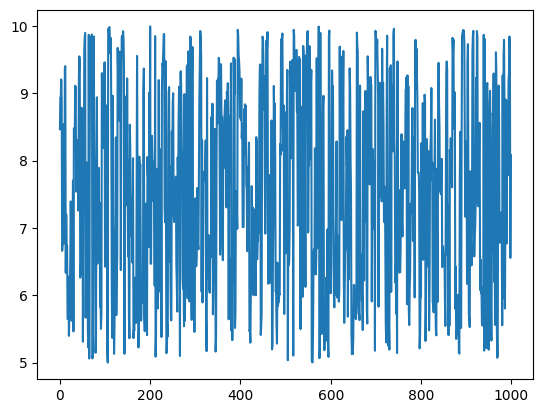

In [46]:
plt.plot(mcmc.get_samples()['x']);

In [2]:
def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(0, 10))
    numpyro.sample(
        'constraint',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.greater_than(5), (), (),
        ),
        obs = x,
    )

In [3]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.key(0))

sample: 100%|███████████████████████| 2000/2000 [00:03<00:00, 501.55it/s, 1 steps of size 3.17e-01. acc. prob=0.79]


In [4]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      7.50      1.48      7.46      5.42      9.93     94.42      1.01

Number of divergences: 501


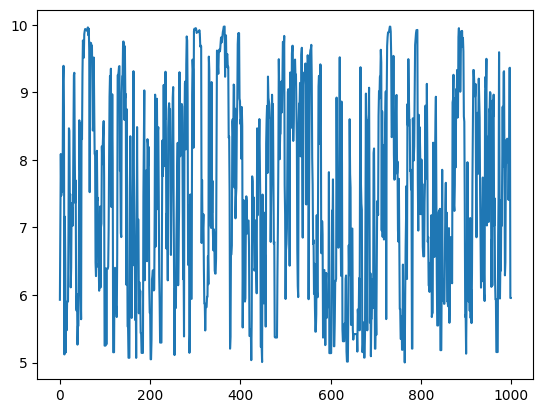

In [5]:
plt.plot(mcmc.get_samples()['x']);

## beta test

In [6]:
def alpha_beta_to_mu_sigma(alpha, beta):
    mu = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    return mu, var ** 0.5

def mu_sigma_to_alpha_beta(mu, sigma):
    alpha = (mu ** 2 * (1 - mu) - mu * sigma ** 2) / sigma ** 2
    beta = (mu * (1 - mu) ** 2 - (1 - mu) * sigma ** 2) / sigma ** 2
    return alpha, beta

In [11]:
def model():
    mu = numpyro.sample('mu', numpyro.distributions.Uniform(0, 1))
    sigma = numpyro.sample('sigma', numpyro.distributions.Uniform(0.1, 1))
    # var = numpyro.sample('var', numpyro.distributions.Uniform(0.005, 0.25))
    # sigma = numpyro.deterministic('sigma', var**0.5)
    alpha, beta = mu_sigma_to_alpha_beta(mu, sigma)
    numpyro.sample(
        'alpha_constraint',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.greater_than(1), (), (),
        ),
        obs = alpha,
    )
    numpyro.sample(
        'beta_constraint',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.greater_than(1), (), (),
        ),
        obs = beta,
    )

In [12]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.key(0))

/home/matthew.mould/.conda/envs/gpu/lib/python3.10/site-packages/jax/_src/linear_util.py:396: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  ans = _fun(*args, **kwargs)
sample: 100%|███████████████████████| 2000/2000 [00:07<00:00, 285.08it/s, 1 steps of size 4.45e-01. acc. prob=0.54]


In [13]:
mu = mcmc.get_samples()['mu']
sigma = mcmc.get_samples()['sigma']
alpha, beta = mu_sigma_to_alpha_beta(mu, sigma)

In [16]:
sigma.max()

Array(0.28600772, dtype=float64)

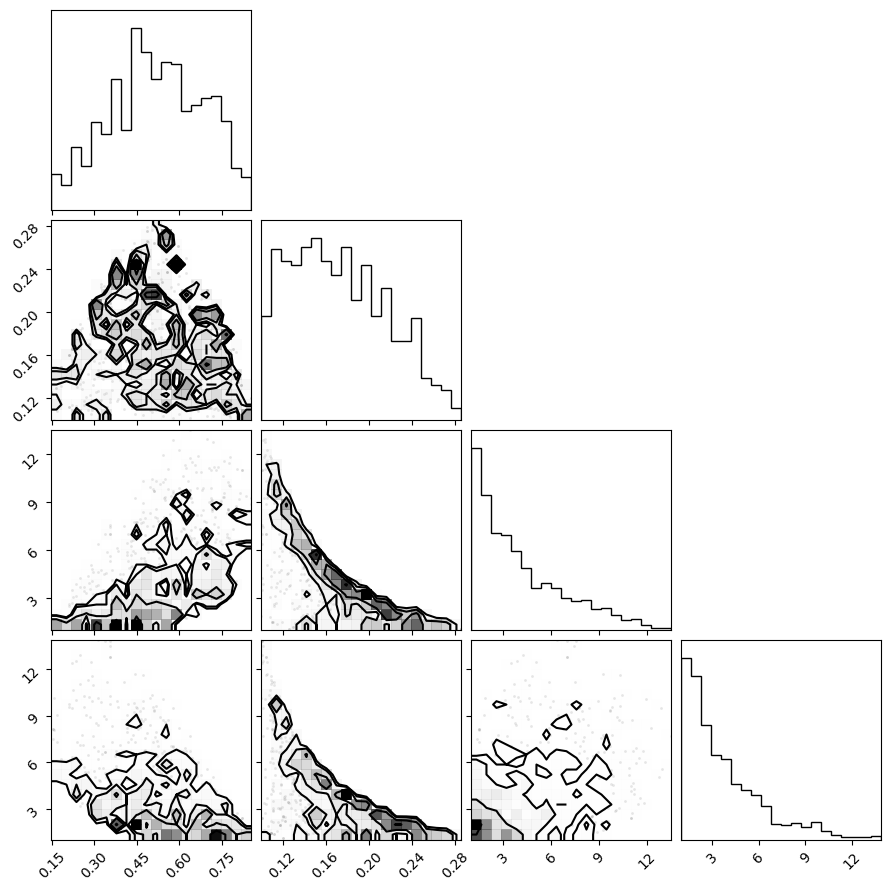

In [15]:
corner(np.transpose([mu, sigma, alpha, beta]));
# corner(np.transpose([mu, sigma, np.log10(alpha), np.log10(beta)]));

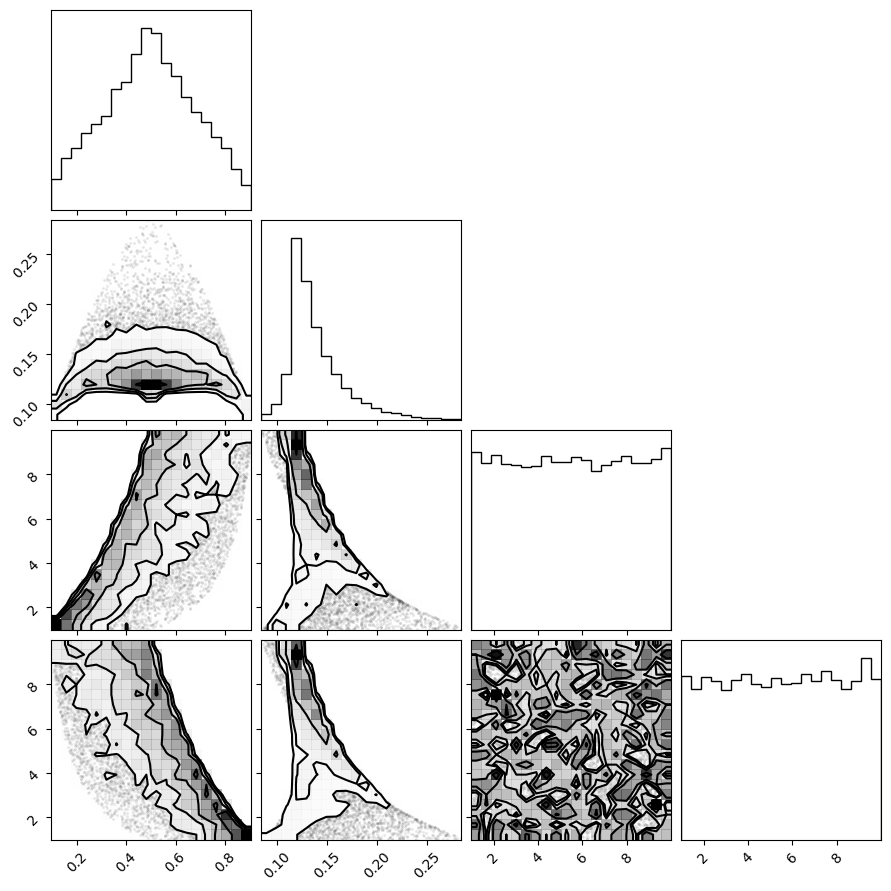

In [41]:
alpha = jax.random.uniform(jax.random.key(100), (10_000,)) * 9 + 1
beta = jax.random.uniform(jax.random.key(101), (10_000,)) * 9 + 1
mu, sigma = alpha_beta_to_mu_sigma(alpha, beta)
corner(np.transpose([mu, sigma, alpha, beta]));
# corner(np.transpose([mu, sigma, np.log10(alpha), np.log10(beta)]));